## Imports

In [24]:
#List of imports

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import skew, pearson3
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from hmmlearn import hmm

import urllib.request
import zipfile
import cvxpy as cp
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import itertools
import random

random.seed(50)

## Additions below
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import matplotlib.pyplot as plt

In [3]:
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')

## Class Definitions Data/Portfolio


In [4]:
class Data:
    #Anything Data Related
    def __init__(self, stock_prices, risk_free, universe=None,factor_type='PCA', period='M'):
        #TO-DO: Add initialization of market cap
        
        if not universe:
            universe = stock_prices.columns
            
        if type(universe[0]) == int:
            self.stock_prices = stock_prices.iloc[:,universe]

        else:
            self.stock_prices = stock_prices[universe]
        
        self.risk_free = risk_free
        self.risk_free.index = pd.to_datetime(self.risk_free.index)
        self.risk_free = self.risk_free.resample(period).last()
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)
        self.stock_returns=self.get_stock_returns(period)
        self.factor_returns= self.get_factor_returns(factor_type)
 
        return
    
    def get_stock_returns(self, period='M'):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)

        return ret_data

    def get_factor_returns(self, factor_type='PCA', period='M'):
        if factor_type == 'CAPM':
         
            return self.get_CAPM_returns(period)
        
        elif factor_type == 'FF':
       
            return self.get_FF_returns(period)
            
        elif factor_type == 'Carhart':
           
            return self.get_Carhart_returns(period)
            
        elif factor_type == 'PCA':
           
            return self.get_PCA_returns(period)
        
        else:
            print("Invalid input: Please select one of the following factor types: CAPM, FF, Carhart or PCA.")
        
        return   
    
    def get_FF_returns(self, period='M'):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)

        return ff_factors
    
    def get_CAPM_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)
        
        # Remove the unnecessary factors
        capm_factors = ff_factors.iloc[:, 0]
        
        return capm_factors
    
    def get_Carhart_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)

        # Get the momentum factor
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

        # Download the file and save it  
        urllib.request.urlretrieve(momentum_url,'momentum.zip')
        zip_file = zipfile.ZipFile('momentum.zip', 'r')

        # Extact the file data
        zip_file.extractall()
        zip_file.close()

        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)

        # Skip null rows
        row = momentum_factor.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)

        # Format the date index
        momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')

        # Format dates to end of month
        momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()

         # Resample the data to correct frequency
        momentum_factor = momentum_factor.resample(period).last()

        # Convert from percent to decimal
        momentum_factor = momentum_factor.apply(lambda x: x/ 100)

        # Combine to create the carhart_factors
        carhart_factors = pd.concat([ff_factors, momentum_factor], axis=1).dropna()

        return carhart_factors
    
    def get_PCA_returns(self, period='M'):
        exRets = self.get_stock_returns(period="D")
        num_stocks = len(exRets.columns)
        returns_mat = exRets.to_numpy()
        n_dates = returns_mat.shape[0]
        n_assets = returns_mat.shape[1]
        
        demeaned = (returns_mat - returns_mat.mean(axis=0)).transpose()
        sigma = 1/(n_dates - 1)*np.matmul(demeaned,demeaned.transpose())
        eigval, eigvec = np.linalg.eig(sigma)
        
        principal_components = np.matmul(eigvec.transpose(),demeaned).transpose()
        pca_factors = np.real(principal_components[:,0:10])
        
        pca_df = pd.DataFrame(pca_factors, index = exRets.index, columns = [str(i) for i in range(10)])
        pca_df = pca_df.resample(period).last()
        
        return pca_df
    
    def get_index_from_date(self, date_index_df, date):
        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
    
    def get_num_stocks(self):
        return len(self.stock_returns.columns)

    
class Portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, data):       
        num_stocks=data.get_num_stocks()
        self.weights= np.array([[0]*num_stocks + [1]]) # 0 weight on stock
        self.returns= np.array([])
        self.dates= []
        return
        
    def update_weights(self, new_weights):
        
        new_weights = np.expand_dims(new_weights, axis=0)
        self.weights = np.append(self.weights, new_weights, axis=0)
        return
     
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        return

    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        return
        
    def get_Sharpe(self, data):
        risk_free = data.risk_free
        recent_date = self.dates[-1]
        sigma = np.std(self.returns - np.array(risk_free.loc[self.dates]))
#         sharpe_ratio = ((np.prod(1 + self.returns - np.array(risk_free.loc[recent_date]))**(1/len(self.returns))
#                          -1))/sigma
        sharpe_ratio = (stats.gmean(self.returns-np.array(risk_free.loc[recent_date]) + 1,axis=0) - 1)/sigma
    
        annual_sharpe = sharpe_ratio*(np.sqrt(12))
        return annual_sharpe
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.show()
    


## Class Definitions: Cost/Constraints

In [5]:
class Costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost = 0
        self.trans_cost = 0
        self.trans_coeff = trans_coeff
        self.holding_coeff = holding_coeff
        return
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl = np.ones((num_stocks,lookahead))
        holding_cost_repl = np.ones((num_stocks, lookahead))
        self.trans_coeff = trans_cost_repl*self.trans_coeff
        self.holding_coeff = holding_cost_repl*self.holding_coeff
        return
    
    def set_holding_cost(self, weights_new):
        self.holding_cost += cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        return
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def set_trans_cost(self, weights_new, weights_old):
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future = weights_new[:,1:]
            weights_future_shift = weights_new[:,:-1]
            self.trans_cost = self.calc_trans_cost(weights_future, weights_future_shift, self.trans_coeff[:,1:])

        self.trans_cost += self.calc_trans_cost(weights_curr, weights_old,self.trans_coeff[:,0])
        return


class Constraints:
        #List of all constraints
        def __init__(self, constr_list=['asset_limit_cardinality'], 
                     upper_limit=0.25, lower_limit=0, turn_over=0.1, stock_limit=11, M=0.3):
            self.upper_limit = upper_limit
            self.lower_limit = lower_limit
            self.stock_limit = stock_limit
            self.turn_over= turn_over
            self.constr_list = constr_list
            self.M = M
            self.value=[]

        
        def set_constraints(self, all_weights, weights_prev, y, b=None, cvar=False, gamma=None, z=None, r=None):
            
            # weights is without risk free
            weights=all_weights[:-1,:]
           
            #unity condition
            self.value += [cp.sum(all_weights,axis=0)==1]
            
            #can never be short cash
            self.value += [all_weights[-1,:]>=0]
            
            num_stocks=weights.shape[0]
            
            if cvar:
                self.value += [z >= 0]
                self.value += [z >= -r@weights-gamma]
            
            if "no_short" in self.constr_list:
                self.value+=  [weights>=0]
                
            if "turn_over" in self.constr_list:
                weight_curr=weights[:,0]
                self.value += [cp.abs(weight_curr)-weights_prev<= self.turn_over]
            
                
            if "asset_limit_cardinality" in self.constr_list:
                upper_limit= cp.multiply(self.upper_limit, y)
                lower_limit = cp.multiply(self.lower_limit,y)
                
                #ensure that at least 1 but no more than 2 in each sector
                self.value += [cp.sum(y[:,0])<= self.stock_limit]
                self.value += [cp.sum(y[:,0])>= 5]
#                 for i in range(0,num_stocks,4):
#                     self.value += [y[i:i+3]>=1]
                   # self.value += [y[i:i+3]<=2]
                    
#                 self.value += [weights>=lower_limit, weights<=upper_limit]
                #self.value += [weights+cp.multiply(self.M,b)>=lower_limit, -1*weights+cp.multiply(self.M,1-b)>=lower_limit] 
                #self.value += [weights>= -1*upper_limit, weights<= upper_limit]
                self.value+=[weights>=lower_limit, weights<=upper_limit]
        
            elif "asset_limit" in self.constr_list:
                self.value += [weights>=self.lower_limit, weights<=self.upper_limit]
 
            return



    


## Class Definitions Risk Type/ Optimization Models

In [6]:
class Risks:
    def __init__(self, risk_type="MVO", robust_type="ellip", conf_lvl=0):
        #risk value, return adjustment, risk type and confidence level
        self.value=0
        self.return_adj=0
        self.risk_type=risk_type
        self.robust_type=robust_type
        self.conf_lvl=conf_lvl
        return
        
    def set_risk(self, weights, Q, lookahead=1, S=5000, gamma=None, z=None, alpha=None):
        
        portfolio_risk=0
        robustness_cost=0
        num_stocks = weights.shape[1]
        
        if self.risk_type== "MVO":
        
            for i in range(lookahead):
                portfolio_risk += cp.quad_form(weights[:,i], Q[i])        
            self.value = portfolio_risk
            
        elif self.risk_type == "CVAR":
            if not S or not gamma or not z or not alpha:
                print("Missing one of these required inputs for CVaR optimization: S, gamma, z, alpha")
                return
            self.value = gamma + (1/((1-alpha)*S))*cp.sum(z)
        
        if self.robust_type == "rect":
            
            for i in range(lookahead):
                delta = stats.norm.ppf(self.conf_lvl)*np.sqrt(np.diag(Q[i]/num_stocks))
                robustness_cost += delta@cp.abs(weights[:,i])
    
            self.return_adj= robustness_cost
        
        elif self.robust_type == "ellip":
            
            for i in range(lookahead):
         
                penalty = cp.norm(np.sqrt(np.diag(Q[i]/num_stocks))@weights[:,i],2)
                robustness_cost += stats.chi2.ppf(self.conf_lvl, num_stocks)*penalty
                

            self.return_adj = robustness_cost
            
    
        return

    def get_RP_objective(self, weights, args):
        Q = args[0]
        assets_risk_budget = args[1]
        lookahead = args[2]
        cost_model = args[3]
        
        num_stocks = len(assets_risk_budget)

        self.value=0
        # We convert the weights to a matrix
        weights = np.matrix(weights)
        for i in range(lookahead):
            # We calculate the risk of the weights distribution

            portfolio_risk = np.sqrt((weights[0,num_stocks*i:num_stocks*(i+1)] * Q[i] 
                                      * weights[0,num_stocks*i:num_stocks*(i+1)].T))[0, 0]

            # We calculate the contribution of each asset to the risk of the weights
            # distribution
            assets_risk_contribution = np.multiply(weights[0,num_stocks*i:num_stocks*(i+1)].T, Q[i] 
                                                   * weights[0,num_stocks*i:num_stocks*(i+1)].T)/ portfolio_risk

            # We calculate the desired contribution of each asset to the risk of the
            # weights distribution
            assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

            # Error between the desired contribution and the calculated contribution of
            # each asset
            self.value += np.sum(np.square(assets_risk_contribution - assets_risk_target.T))
            
            # Get the holding costs
            self.value += np.sum(cost_model.holding_coeff[0,0]*weights[0,num_stocks*i:num_stocks*(i+1)])
            
            # Get the transaction costs
            if i < lookahead-1:
                abs_trade = np.abs(weights[0, num_stocks*i:num_stocks*(i+1)]-
                                   weights[0, num_stocks*(i+1):num_stocks*(i+2)])
                self.value += np.sum(cost_model.trans_coeff[0,0]*abs_trade)
            
        # It returns the calculated error
        return self.value 
    
    
    
class Model:
    def __init__(self, look_ahead, goal_ret):
        self.opt_weights = 0
        self.status = None
        self.look_ahead=look_ahead
        self.goal_ret=goal_ret
        return
        
    def Solver(self, port, mu , Q, rf, constr_model, cost_model, risk_model,data=None, t=None,lookback=None,scen_model=None):
        
        mu_np = np.array(mu)
   
        Q_np = np.array(Q)
 
        num_stocks = port.weights.shape[1]-1
        num_simulations=5000
        
        if risk_model.risk_type =="CVAR":
            self.look_ahead=1
            mu_np = np.array(mu)[0,:]
            mu_np = np.expand_dims(mu_np, axis=0)
        
        
        #Construct optimization problem
        all_weights = cp.Variable((num_stocks+1,self.look_ahead))   
        y = cp.Variable((num_stocks,self.look_ahead), boolean=True)
        b = cp.Variable((num_stocks,1), boolean=True)
        z = cp.Variable((num_simulations,1)) 
        g = cp.Variable(1) 
        
        weights_prev= port.weights[-1,:-1]   
        weights=all_weights[:-1,:]

        # Set model parameters
        cost_model.set_trans_cost(weights, weights_prev)
        cost_model.set_holding_cost(weights)    
   
     
        
        if risk_model.risk_type=="CVAR":
            constr_model.set_constraints(all_weights,weights_prev, y, b, cvar=True, gamma=g, z=z, r=scen_model.value)
            risk_model.set_risk(weights, Q, S=5000, gamma=g, z=z, alpha=0.99)
        elif risk_model.risk_type=="MVO":

            constr_model.set_constraints(all_weights, weights_prev, y, b)
            risk_model.set_risk(weights, Q, self.look_ahead)

        # Get portfolio return
        portfolio_return_per_period = mu_np@weights
        rf_return = cp.sum(rf*all_weights[-1,:])
        portfolio_return = cp.trace(portfolio_return_per_period)+rf_return 
        
        #Max return objective
        #objective= cp.Maximize(portfolio_return-risk_model.return_adj)
        
        #Minimize risk objective
        objective= cp.Minimize(risk_model.value)
        constr_model.value+= [portfolio_return - risk_model.return_adj-cost_model.trans_cost -cost_model.holding_cost >=self.goal_ret]
        
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI", verbose=False)
        self.status= prob.status

        temp_goal_ret = self.goal_ret
        counter=0
        while self.status!="optimal":
          
            print("Unsolvable, Reducing Return Target")
            temp_goal_ret= 0.8*temp_goal_ret
            if (counter>3):
                temp_goal_ret=-0.0005
                
                second_counter = 0
                while self.status!="optimal":
                    temp_goal_ret=temp_goal_ret*2
                    second_counter += 1
                    
                    print("Temporary Goal Return is:", temp_goal_ret)
                    new_constr= [portfolio_return - risk_model.return_adj-cost_model.trans_cost -cost_model.holding_cost >=temp_goal_ret]
                    constr_model.value= constr_model.value[:-1]+ new_constr
                    prob= cp.Problem(objective, constr_model.value)
                    result=prob.solve(solver="GUROBI")
                    self.status= prob.status
                    
            
            if self.status!="optimal":
                print("Temporary Goal Return is:", temp_goal_ret)
                new_constr= [portfolio_return - risk_model.return_adj-cost_model.trans_cost -cost_model.holding_cost >=temp_goal_ret]
                constr_model.value= constr_model.value[:-1]+ new_constr
                prob= cp.Problem(objective, constr_model.value)
                result=prob.solve(solver="GUROBI")
                self.status= prob.status
                counter+=1
            
        
        self.opt_weights=np.array(all_weights.value)[:,0]
        print("Goal returns:", temp_goal_ret)
        print("port return raw:",portfolio_return.value)
        print("robustness cost:", risk_model.return_adj.value)
        print("risk value:",risk_model.value.value)
        print("holding cost:",cost_model.holding_cost.value)
        print("trans cost:", cost_model.trans_cost.value)
     
        return self.opt_weights
    

    def risk_parity(self, port, Q, lookahead, risk_model, cost_model):
        TOLERANCE = 1e-7
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]-1

        #Construct optimization problem
        init_weights = np.tile(port.weights[-1,:-1],lookahead).astype(float)
        init_rf = port.weights[-1,-1]
        weight_total = 1-init_rf
        
        if np.count_nonzero(init_weights)==0:
            init_weights = np.array([1/num_stocks]*num_stocks*lookahead)
            weight_total=1
            init_rf = 0
        
        # The desired contribution of each asset to the portfolio risk: we want all
        # assets to contribute equally
        assets_risk_budget = [1/num_stocks] * num_stocks

        # Optimisation process of weights
        # Restrictions to consider in the optimisation: only long positions whose
        # sum equals 100%
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - weight_total},
                       {'type': 'ineq', 'fun': lambda x: x})

        # Optimisation process in scipy
        optimize_result = minimize(fun=risk_model.get_RP_objective,
                                   x0=init_weights,
                                   args=[Q, assets_risk_budget, lookahead, cost_model],
                                   method='SLSQP',
                                   constraints=constraints,
                                   tol=TOLERANCE,
                                   options={'disp': False, 'maxiter':5000}
                                  )

        # Recover the weights from the optimised object
        weights = np.array(optimize_result.x) 
        
        self.opt_weights = np.concatenate((weights[0:num_stocks], np.array([init_rf])))
        return self.opt_weights        

 

In [7]:
class Scenarios:
    def __init__(self, mode):
        self.mode=mode
        self.value=None
    def gen_scenarios(self, S, data, t, lookback):
        if self.mode==0:
            factor_returns = data.get_factor_returns()
            prev_factor_returns = factor_returns[:t]


            mu_simulated_arr = []


            returns_data = data.stock_returns
            factor_data = data.factor_returns

            n_factors = len(factor_data.columns)

            returns_data = data.get_lookback_data(returns_data, t, lookback)
            factor_data = data.get_lookback_data(factor_data, t, lookback)

            factor_data['Ones'] = [1 for i in range(len(factor_data))]


            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()


            # RIDGE REGRESSION
            model_ridge = Ridge().fit(X,Y)

            # SUPPORT VECTOR REGRESSION
            model_SVR = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)


            sim_list = []

            for j in range(n_factors):
                fac_ret = prev_factor_returns.iloc[:,j].to_numpy()
                skew_val = skew(fac_ret)
                mean_val = np.mean(fac_ret)
                std_val = np.std(fac_ret)
                sim_list.append(pearson3.rvs(skew=skew_val, loc=mean_val, scale=std_val, size=S))

            sim_list.append(np.ones(S))

            mu_simulated_arr = []
            for i in range(S):
                #  Calculate the asset expected excess returns
                mu_ridge = model_ridge.predict([np.array(sim_list)[:,i]])[0]
                mu_SVR = model_SVR.predict([np.array(sim_list)[:,i]])[0]

                # Ensemble the methods
                mu = 0.25*mu_ridge + 0.75*mu_SVR

                mu_simulated_arr.append(mu)


            self.value= np.array(mu_simulated_arr)
        elif self.mode==1:
            returns_data = data.stock_returns
            rets = data.get_lookback_data(returns_data, t, lookback)
            num_stocks=data.get_num_stocks()
            num_dates=len(rets.index)
            num_scen=S
            dof=4
            mat_idx= np.random.randint(0,num_dates-1,(num_scen,30))
            chi_squared_mult= np.sqrt(dof/np.random.chisquare(dof,(num_scen,1)))
            rets_rank=rets.rank()/100
            rets_gauss= stats.norm.ppf(rets_rank)
            mat_gauss=rets_gauss[mat_idx]
            gauss_sum=mat_gauss.sum(axis=1)
            t_student=np.multiply(gauss_sum,chi_squared_mult)
            copula= stats.t.cdf(t_student,dof)
            empir=np.zeros((num_scen, num_stocks))
            for i in range(num_stocks):
                empir[:,i]=np.quantile(rets.iloc[:,i].T, copula[:,i])
            self.value=empir

        



## Factor Models

In [37]:
class FactorModel:
    def __init__(self, lookahead, lookback, regress_weighting):
        
        """
        lookahead: number of periods in the future to estimate
        lookback: number of periods in the past to use for estimations
        regress_weighting: array of size 4 with weight corresponding to each regression type; adds up to 1; 
        order is linear, lasso, ridge, SVR; in the case where there is one 1 and the rest 0's, there is no ensembling;
        can artifically call LSTM by setting all weights to 0
        """
        self.lookahead = lookahead
        self.lookback = lookback
        self.regress_weighting = regress_weighting
        return
               
    def get_param_estimate(self, rebal_date, data):
               
        if sum(self.regress_weighting) == 0:
            return self.get_mu_LSTM(rebal_date, data)

        elif sum(self.regress_weighting) == 1:
            return self.get_mu_Q_regression(rebal_date, data)
        
        else:
            return "ERROR: This regression weighting is not valid. Please make sure the weights sum to 1. You can also give all zeros for LSTM."
        
    def get_mu_Q_regression(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting
                
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)
        


        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)

        
        
        for i in range(0, lookahead):

            # Calculate the factor covariance matrix

            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()
 
            ### LINEAR REGRESSION
        
            model = LinearRegression().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_linear = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_linear = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### LASSO REGRESSION

            model = Lasso().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_lasso = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_lasso = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### RIDGE REGRESSION

            model = Ridge().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_ridge = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_ridge = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### SUPPORT VECTOR REGRESSION

            model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
            beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
            alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_SVR = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_SVR = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

        
            # Ensemble the methods
            mu = regress_weighting[0]*mu_linear + regress_weighting[1]*mu_lasso + regress_weighting[2]*mu_ridge + regress_weighting[3]*mu_SVR
            Q = regress_weighting[0]*Q_linear + regress_weighting[1]*Q_lasso + regress_weighting[2]*Q_ridge + regress_weighting[3]*Q_SVR

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        
        lookahead = self.lookahead
        lookback = self.lookback
        #regress_weighting = self.regress_weighting
        
        start_date="2008-01-01"
        returns_data = returns_data.loc[start_date:rebal_date]
        factor_data = factor_data.loc[start_date:rebal_date]

        
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)

        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())
        _, Q= self.get_mu_Q_regression(rebal_date,data)
        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu,Q
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance

            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)

        #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)

        history = [x for x in train_x]

        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        print(factor_data.tail(lookback).shape)
        return self.forecast(model, factor_data.tail(lookback), lookback)


## HMM

In [9]:
class Regime:
    def __init__(self, data ,t, first_date= "2000-01-01"):
        self.train_prices=None
        self.train_returns=None
        self.train_dates=None
        self.get_train_data(data,t, first_date)

    def get_train_data(self, data, t,first_date):
        mkt_data = data.factor_returns["Mkt-RF"]+data.factor_returns["RF"]
        mkt_returns=mkt_data[first_date:t]
        self.train_dates=mkt_returns.index

        mkt_returns=np.array(mkt_returns.values)
        mkt_prices = 100*(np.array([x+1 for x in mkt_returns]).cumprod())
        mkt_prices=np.expand_dims(mkt_prices,axis=1)
        mkt_returns=np.expand_dims(mkt_returns,axis=1)
        
        self.train_prices=mkt_prices
        self.train_returns=mkt_returns

    def HMM (self, num_hs):
        model=hmm.GaussianHMM(n_components=num_hs)
        model.fit(self.train_returns)
        return model
    
    def predict_next(self, num_hs=2):
        reg_model = self.HMM(num_hs)
        out=reg_model.predict(self.train_returns)
        transmat=reg_model.transmat_
        gauss_means= reg_model.means_
        gauss_cov= reg_model.covars_

        bull_idx=np.argmax(reg_model.means_)
        bear_idx= 1-bull_idx
        seq= reg_model.predict(self.train_returns)
        next_state= np.argmax(transmat[seq[-1]])
        if bull_idx==next_state:
            self.reg_pred="bull"
     
        else:
            self.reg_pred="bear"

        self.trans_conf= transmat[seq[-1]][next_state]
        self.reg_conf= stats.norm.cdf(self.train_returns[-1],gauss_means[next_state], np.sqrt(gauss_cov[next_state]))[0][0]

## Backtester/ Livetester

In [112]:
    
class Backtest:
    def __init__(self, start_date, end_date, period='M'):
        self.rebal_freq = period
        self.start_date = start_date
        self.end_date = end_date        

        return
        
  

    def run(self, data, portfolio, risk_profile, factor_model, conf_level, constraints, u_lim=0.25,l_lim=0.05,stock_lim=10, risk_type="MVO",scen_type=0):      
        look_back= factor_model.lookback
        look_ahead= factor_model.lookahead
        stock_return= data.stock_returns      
        reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
        
        for t in reb_dates:

            trans_coeff = 0.01
            holding_coeff = 0.05

            risk_model = Risks(risk_type, "ellip", conf_level)
            scen_model= None
            
            if risk_type=="CVAR":
                scen_model=Scenarios(scen_type)
                scen_model.gen_scenarios(5000,data,t,look_back)
                
            
            #Set up models based on regime hyperparameters
            constr_model = Constraints(constraints, upper_limit=u_lim, 
                                       lower_limit=l_lim, stock_limit=stock_lim)

            #Set up cost models
            cost_model = Costs(trans_coeff, holding_coeff)
            cost_model.replicate_cost_coeff(num_stocks, look_ahead)

            raw_return = (1+risk_profile)**(1/12)-1
            opt_model = Model(look_ahead,raw_return)


            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])            
            
            weights = opt_model.Solver(portfolio, mu , Q, new_rf_rate, constr_model, cost_model, risk_model, data, t,look_back,scen_model)     
            

            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

        return portfolio.get_Sharpe(data)

    
class Livetest:
    def __init__(self, start_date, end_date, period='M'):
        self.rebal_freq = period
        self.start_date = start_date
        self.end_date = end_date        

        return
        
    
    def run(self, data, portfolio, risk_profile, factor_model):      
        look_back= factor_model.lookback
        look_ahead= factor_model.lookahead
        stock_return= data.stock_returns      
        reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
        
        for t in reb_dates:
            #need some dynamic adjustment here... how to set risk_model confidence level, cost_coefficieints,
            #constraint asset limits, goal_return ,, factor_model, opt_model, constr_model, cost_model, risk_model
            
            #detect regime
            hmm_model= Regime(FF_data,t)
            hmm_model.predict_next()
            
            # ADJUST THIS STUFF BELOW
            if hmm_model.reg_pred== "bull":
                #CVaR here
                #regime dependent coefficients
                #print("trans_conf:", hmm_model.trans_conf)
                #print("reg_conf", hmm_model.reg_conf)
                regime_ret_adj= 1+ 0.1*hmm_model.trans_conf +0.1*hmm_model.reg_conf
                raw_return = (1+risk_profile)**(1/12)-1
                adj_return= regime_ret_adj*raw_return
                trans_coeff = 0.01
                holding_coeff = 0.05
                conf_level = 0.25
                constr_list = ["asset_limit_cardinality"]
                risk_model = Risks("CVAR", "ellip", conf_level)
                scen_model=Scenarios(1)
                scen_model.gen_scenarios(5000,data,t,lookback)
                
                
            elif hmm_model.reg_pred== "bear":
                #MVO here
                #regime dependent coefficients
                regime_ret_adj=1- 0.1*hmm_model.trans_conf -0.1 * hmm_model.reg_conf
                raw_return = (1+risk_profile)**(1/12)-1
                adj_return= regime_ret_adj*raw_return
                trans_coeff = 0.01
                holding_coeff = 0.01
                conf_level = 0.75
                constr_list = ["asset_limit_cardinality"]
                risk_model= Risks("MVO", "ellip", conf_level)
                scen_model=None
            
            #Set up models based on regime hyperparameters
            constr_model = Constraints(constr_list, upper_limit=u_lim, 
                                       lower_limit=l_lim, stock_limit=stock_lim)

            #Set up cost models
            cost_model = Costs(trans_coeff, holding_coeff)
            cost_model.replicate_cost_coeff(num_stocks, lookahead)

            opt_model = Model(lookahead,raw_return)

            
            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])            
            
            weights = opt_model.Solver(portfolio, mu , Q, new_rf_rate, constr_model, cost_model, risk_model, data, t,look_back,scen_model)     
            

            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

        return portfolio.get_Sharpe(data)


# Main - Backtest Engine

In [ ]:
##Main


#Set up Data
price_data = pd.read_csv("../Data/small_universe.csv", index_col='Date').fillna(method="bfill")
rf = (1+price_data["10 YR"])**(1/12)-1
universe=['ETN', 'AME', 'AAL', 'CHRW',
          'ABT', 'AMGN', 'VRTX', 'ALGN',
          'AAPL', 'ADBE', 'AMD', 'ADS',
          'T', 'CMCSA', 'ATVI', 'CHTR',
          'AMZN', 'F', 'DG', 'CMG',
          'DUK', 'LNT', 'AES', 'FE',
          'C', 'BAC', 'CBOE', 'RE',
          'APD', 'FMC', 'BLL', 'CF',
          'DRE', 'BXP', 'EQIX', 'CCI',
          'CL', 'KMB', 'KR', 'STZ',
          'CVX', 'XOM', 'COG', 'APA']
data = Data(price_data, rf,universe)

#Set up Portfolio
port=Portfolio(data)

#Set up Variables
num_stocks=data.get_num_stocks()
start_date = "2018-11-30"
end_date = "2020-11-01"
#1 year lookback
lookback = 12 
lookahead = 1


high_risk_ret=0.15
medium_risk_ret=0.1
low_risk_ret= 0.05

# trans_coeff, holding_coeff, conf_level
lam = (1+high_risk_ret)**(1/12)-1
trans_coeff = 0.001
holding_coeff = 0.01
conf_level = 0.2


#Set up constraints
constr_list = ["asset_limit_cardinality"]
constr_model = Constraints(constr_list)

#Set up cost models
cost_model = Costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, lookahead)

opt_model = Model(lookahead,lam)
risk_model = Risks("MVO", "ellip", conf_level)

regress_weighting = [0,0,0.25,0.75]
factor_model = FactorModel(lookahead, lookback, regress_weighting)

back_test = Backtest(start_date, end_date)
back_test.run(data, port, factor_model, opt_model, constr_model, cost_model, risk_model)


Goal returns: 0.01171491691985338
port return raw: 0.019233501762112436
risk value: 0.0015463424439557504
holding cost: 0.0
trans cost: 0.0005693789741329834
Goal returns: 0.01171491691985338
port return raw: 0.01956679667064477
risk value: 0.0017165051806411185
holding cost: 0.0
trans cost: 0.0005843845931508148
Goal returns: 0.01171491691985338
port return raw: 0.022637574519412597
risk value: 0.0037400119918096714
holding cost: 0.0
trans cost: 0.0008419647264258943
Goal returns: 0.01171491691985338
port return raw: 0.021641094896124872
risk value: 0.003187620588195517
holding cost: 0.0
trans cost: 0.0009746277573195801
Goal returns: 0.01171491691985338
port return raw: 0.018495606890763846
risk value: 0.0011469399977096263
holding cost: 0.0
trans cost: 0.0008986939316996839
Goal returns: 0.01171491691985338
port return raw: 0.01847386755493706
risk value: 0.0011051770122231545
holding cost: 0.0
trans cost: 0.0006954583246314469
Goal returns: 0.01171491691985338
port return raw: 0.01

In [ ]:
port.weights[5]

## Main - Live Test Engine

In [38]:
##Main

#Set up Data
price_data = pd.read_csv("../Data/small_universe.csv", index_col='Date').fillna(method="bfill")
rf = (1+price_data["10 YR"])**(1/12)-1
universe=['ETN', 'AME', 'AAL', 'CHRW',
          'ABT', 'AMGN', 'VRTX', 'ALGN',
          'AAPL', 'ADBE', 'AMD', 'ADS',
          'T', 'CMCSA', 'ATVI', 'CHTR',
          'AMZN', 'F', 'DG', 'CMG',
          'DUK', 'LNT', 'AES', 'FE',
          'C', 'BAC', 'CBOE', 'RE',
          'APD', 'FMC', 'BLL', 'CF',
          'DRE', 'BXP', 'EQIX', 'CCI',
          'CL', 'KMB', 'KR', 'STZ',
          'CVX', 'XOM', 'COG', 'APA']
data = Data(price_data, rf,universe)
FF_data=Data(price_data, rf,universe,"FF")

#Set up Portfolio
port=Portfolio(data)

#Set up Static Variables
num_stocks=data.get_num_stocks()
start_date = "2019-11-30"
end_date = "2020-11-01"
lookback = 12 
lookahead = 1


high_risk_ret=0.15
medium_risk_ret=0.10
low_risk_ret= 0.05

regress_weighting = [0,0,0,0]
factor_model = FactorModel(lookahead, lookback, regress_weighting)


live_test = Livetest(start_date, end_date)
live_test.run(data, port, high_risk_ret, factor_model)

(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.019084375645252876
robustness cost: 0.0
risk value: [0.05254717]
holding cost: 0.0
trans cost: 0.007369458725399496
(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.013590258160659056
robustness cost: 0.0
risk value: [0.03463677]
holding cost: 0.0
trans cost: 0.0018753412408056777
(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.01522079943525956
robustness cost: 0.0
risk value: [0.03543005]
holding cost: 0.0
trans cost: 0.0035058825154061805
(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.013365276679686478
robustness cost: 0.0
risk value: [0.02344139]
holding cost: 0.0
trans cost: 0.0016503597598330998
(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.021839241413532624
robustness cost: 0.0
risk value: [0.04220025]
holding cost: 0.0
trans cost: 0.010124324493679244
(12, 10)
data

(12, 10)
data size
(12, 10)
Goal returns: 0.01171491691985338
port return raw: 0.013671785495828672
robustness cost: 0.0
risk value: [0.01943729]
holding cost: 0.0
trans cost: 0.0019568685759752914


0.5083540864207133

In [45]:
port.weights[5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.25      , 0.25      , 0.        , 0.25      , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05      ,
       0.10192198, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09807802])

### HMM Diagrams

In [ ]:
t="2020-11-25"
FF_data=Data(price_data, rf,universe,"FF")
reg=Regime(FF_data,t)
reg_model = reg.HMM(2)

In [ ]:
out=reg_model.predict(reg.train_returns)
test=np.array(list(map(bool,out)))

In [ ]:

plt.figure(figsize=(12,6))
plt.scatter(reg.train_dates[test],reg.train_prices[test])
plt.scatter(reg.train_dates[~test],reg.train_prices[~test])

plt.xticks(rotation=45)
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

### Parameter Tuning

In [61]:
price_data = pd.read_csv("../Data/small_universe.csv", index_col='Date').fillna(method="bfill")
rf = (1+price_data["10 YR"])**(1/12)-1
universe=['ETN', 'AME', 'AAL', 'CHRW',
          'ABT', 'AMGN', 'VRTX', 'ALGN',
          'AAPL', 'ADBE', 'AMD', 'ADS',
          'T', 'CMCSA', 'ATVI', 'CHTR',
          'AMZN', 'F', 'DG', 'CMG',
          'DUK', 'LNT', 'AES', 'FE',
          'C', 'BAC', 'CBOE', 'RE',
          'APD', 'FMC', 'BLL', 'CF',
          'DRE', 'BXP', 'EQIX', 'CCI',
          'CL', 'KMB', 'KR', 'STZ',
          'CVX', 'XOM', 'COG', 'APA']
data = Data(price_data, rf,universe)
FF_data=Data(price_data, rf,universe,"FF")

num_stocks=data.get_num_stocks()
lookahead = 1
lookback = 12 
regress_weighting = [0,0,0.25,0.75]
factor_model = FactorModel(lookahead, lookback, regress_weighting)

In [78]:
# New Bull Tuning.. Use CVaR

upper_limit= 0.2
lower_limit= 0.05
stock_limit= 15
conf_level=0.5
constr_list = ['asset_limit_cardinality']

low_risk_profiles = 0.05
med_risk_profiles = 0.1
high_risk_profiles = 0.15

start_date = '2017-01-01'
end_date = '2018-01-01'

back_test = Backtest(start_date, end_date)
MVO_port=Portfolio(data) 
CVAR_port= Portfolio(data)

MVO_sharpe = back_test.run(data, MVO_port, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="MVO")
CVAR_sharpe = back_test.run(data, CVAR_port, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="CVAR")
 

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.004920897151645955
robustness cost: 0.016163043766524075
risk value: 0.00025540868344589546
holding cost: 0.0
trans cost: 0.0024999999999999996
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Tempo

Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Goal returns: -0.008
port return raw: 0.007236409075601177
robustness cost: 0.012351942461710187
risk value: 0.0001495391101177667
holding cost: 1.368859208766849e-08
trans cost: 0.0020000046259316243
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.0061101072867403745
robustness cost: 0.019131351044171744
risk value: [0.01502528]
holding cost: 0.0
trans cost: 0.0025
Unsolvable,

Temporary Goal Return is: -0.002
Goal returns: -0.002
port return raw: 0.024025278859675682
robustness cost: 0.02491398733844493
risk value: [-0.00044118]
holding cost: 0.0
trans cost: 0.0011112915212307501


In [83]:
#plot both
def plot_comparison(port_1,port_2):
    port_cumu_returns = np.array([x+1 for x in port_1.returns]).cumprod()
    port_cumu_returns_live = np.array([x+1 for x in port_2.returns]).cumprod()
    plt.figure(figsize=(12,6))
    plt.plot(port_1.dates, port_cumu_returns)
    plt.plot(port_2.dates,port_cumu_returns_live)
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend(["MVO", "CVAR"])
    plt.show()
    

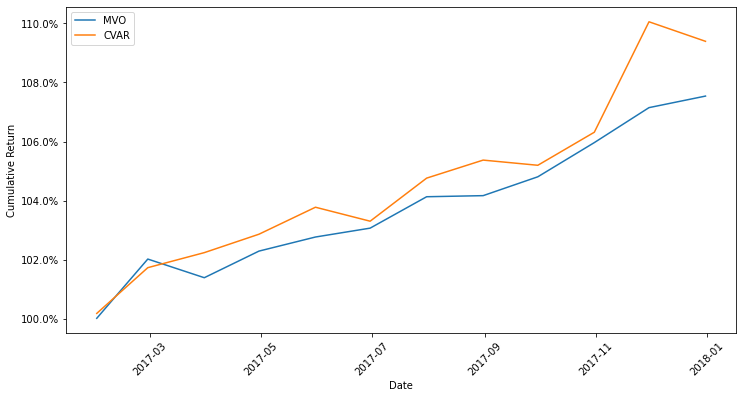

In [84]:
plot_comparison(MVO_port, CVAR_port)

In [85]:
# New bear Tuning.. Use CVaR

upper_limit= 0.2
lower_limit= 0.05
stock_limit= 15
conf_level=0.5
constr_list = ['asset_limit_cardinality']

low_risk_profiles = 0.05
med_risk_profiles = 0.1
high_risk_profiles = 0.15

start_date = '2008-01-01'
end_date = '2009-01-01'

back_test = Backtest(start_date, end_date)
MVO_port_bear=Portfolio(data) 
CVAR_port_bear= Portfolio(data)

MVO_sharpe_bear = back_test.run(data, MVO_port_bear, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="MVO")
CVAR_sharpe_bear = back_test.run(data, CVAR_port_bear, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="CVAR")
 

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Goal returns: -0.004
port return raw: 0.004003633767449297
robustness cost: 0.004938033537560891
risk value: 6.039205044662752e-05
holding cost: 0.0
trans cost: 0.0025
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Tempo

Temporary Goal Return is: -0.004
Goal returns: -0.004
port return raw: 0.012409993144084319
robustness cost: 0.013098754725390235
risk value: [0.00263629]
holding cost: 0.0
trans cost: 0.0025
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Goal returns: -0.004
port return raw: 0.0082525429521553
robustness cost: 0.011016080078814817
risk value: [0.00314271]
holding cost: 0.0
trans cost: 0.001
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Ret

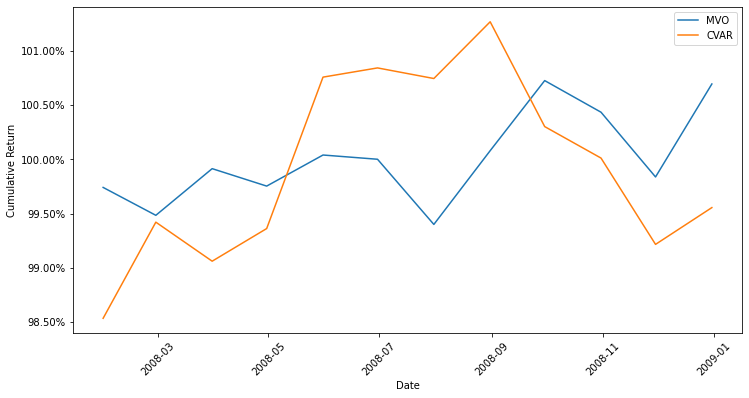

In [86]:
plot_comparison(MVO_port_bear, CVAR_port_bear)

In [89]:
# New Bull Tuning.. Use CVaR

upper_limit= [0.2, 0.25, 0.3, 0.4]
lower_limit= [0.05, 0.1, 0.15, 0.18]
stock_limit= [11, 15, 22, 30]
conf_level=[0.25, 0.50, 0.75, 0.95]
constr_list = [['asset_limit_cardinality'], ['asset_limit_cardinality', 'turn_over']]

low_risk_profiles = 0.05
med_risk_profiles = 0.1
high_risk_profiles = 0.15

start_date = '2017-01-01'
end_date = '2018-01-01'

back_test = Backtest(start_date, end_date)

sharpes = []
portfolio_set=[]
for constr in constr_list:    
    for i in range(4):
        portfolio_set.append(Portfolio(data))
        print("constraints: {} | upper limit: {} | lower limit: {} | stock limit: {} | confidence level: {}"\
              .format(constr, upper_limit[i], lower_limit[i], stock_limit[i],conf_level[i]))
        sharpe = back_test.run(data, portfolio_set[-1], med_risk_profiles, factor_model,conf_level=conf_level[i],constraints=constr, u_lim=upper_limit[i], l_lim=lower_limit[i],
                               stock_lim=stock_limit[i], risk_type="CVAR")
        sharpes.append(sharpe)





constraints: ['asset_limit_cardinality'] | upper limit: 0.2 | lower limit: 0.05 | stock limit: 11 | confidence level: 0.25
Goal returns: 0.007974140428903764
port return raw: 0.020618191976488297
robustness cost: 0.009672126766810027
risk value: [0.04041752]
holding cost: 0.0
trans cost: 0.002971924780774509
Goal returns: 0.007974140428903764
port return raw: 0.016578828749311
robustness cost: 0.006279382693091138
risk value: [0.01228221]
holding cost: 0.0
trans cost: 0.0023253056273160972
Goal returns: 0.007974140428903764
port return raw: 0.01467085010949911
robustness cost: 0.005455216138297715
risk value: [0.01140449]
holding cost: 0.0
trans cost: 0.00014661915345841174
Goal returns: 0.007974140428903764
port return raw: 0.015363943252243616
robustness cost: 0.006343524190965605
risk value: [0.01313357]
holding cost: 0.0
trans cost: 0.001046278632374245
Goal returns: 0.007974140428903764
port return raw: 0.017324068134522204
robustness cost: 0.0071455116098767014
risk value: [0.011

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Goal returns: -0.032
port return raw: 0.01582355307231062
robustness cost: 0.039583549415867926
risk value: [0.02482357]
holding cost: 0.0
trans cost: 0.002
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Te

Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Goal returns: -0.128
port return raw: 0.017142951791105827
robustness cost: 0.1412722892871469
risk value: [0.03616229]
holding cost: 0.0
trans cost: 0.0
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return

Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Temporary Goal Return is: -0.256
Temporary Goal Return is: -0.512
Goal returns: -0.512
port return raw: 0.02223908058607777
robustness cost: 0.5038396426307287
risk value: [0.03888665]
holding cost: 0.0
trans cost: 0.0108
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Re

Goal returns: 0.007974140428903764
port return raw: 0.016293530196366927
robustness cost: 0.006656155756450659
risk value: [0.01658419]
holding cost: 0.0
trans cost: 0.001663234011012499
Goal returns: 0.007974140428903764
port return raw: 0.03458167161089479
robustness cost: 0.00893727116848801
risk value: [-0.00037438]
holding cost: 0.0
trans cost: 0.005665992194150394
Goal returns: 0.007974140428903764
port return raw: 0.03345069039589947
robustness cost: 0.008123577256337796
risk value: [-0.00172572]
holding cost: 0.0
trans cost: 0.001
constraints: ['asset_limit_cardinality', 'turn_over'] | upper limit: 0.25 | lower limit: 0.1 | stock limit: 15 | confidence level: 0.5
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003266207919

Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.03721298333399799
robustness cost: 0.04732748677264383
risk value: [0.00544555]
holding cost: 0.0
trans cost: 0.005885496561354153
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Goal returns: -0.008
port return raw: 0.03780892142641539
robustness cost: 0.043479852230566024
risk value: [0.00294562]
holding cost: 0.0
trans cost: 0.0023290691958493645
constraints: ['asset_limit_ca

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Goal returns: -0.128
port return raw: 0.018133740678103978
robustness cost: 0.1403306907478004
risk value: [0.03646535]
holding cost: 0.0
trans cost: 0.003
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Retu

Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Temporary Goal Return is: -0.256
Temporary Goal Return is: -0.512
Goal returns: -0.512
port return raw: 0.021232084974194862
robustness cost: 0.5194913597876535
risk value: [0.04286834]
holding cost: 0.0
trans cost: 0.0036
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Temporary Goal Return is: -0.256
Temporary Goal Return is: -0.512
Goal returns: -0.5

In [102]:
def plot_comparison(port_list, legend_list):
    plt.figure(figsize=(12,6))
    
    for port in port_list:        
        port_cumu_returns = np.array([x+1 for x in port.returns]).cumprod()
        plt.plot(port.dates, port_cumu_returns)

    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend(legend_list)
    
    plt.show()


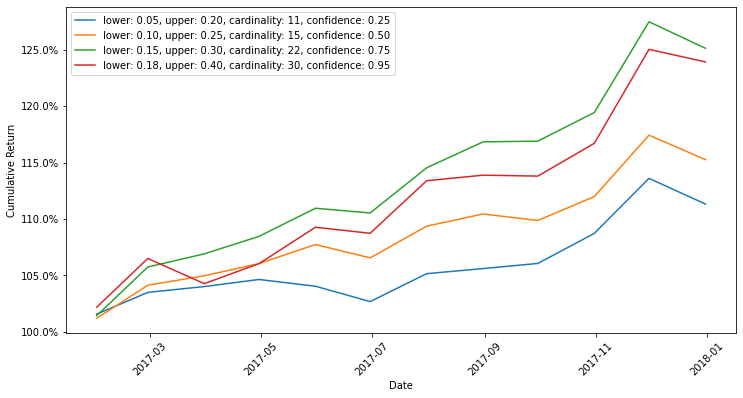

In [105]:
legend_list=["lower: 0.05, upper: 0.20, cardinality: 11, confidence: 0.25","lower: 0.10, upper: 0.25, cardinality: 15, confidence: 0.50","lower: 0.15, upper: 0.30, cardinality: 22, confidence: 0.75","lower: 0.18, upper: 0.40, cardinality: 30, confidence: 0.95"]
plot_comparison(portfolio_set[0:4],legend_list)

In [106]:
# New Bear Tuning.. Use CVaR

upper_limit= [0.2, 0.25, 0.3, 0.4]
lower_limit= [0.05, 0.1, 0.15, 0.18]
stock_limit= [11, 15, 22, 30]
conf_level=[0.25, 0.50, 0.75, 0.95]
constr_list = [['asset_limit_cardinality']]

low_risk_profiles = 0.05
med_risk_profiles = 0.1
high_risk_profiles = 0.15

start_date = '2008-01-01'
end_date = '2009-01-01'

back_test = Backtest(start_date, end_date)

sharpes_bear = []
portfolio_set_bear=[]
for constr in constr_list:    
    for i in range(4):
        portfolio_set_bear.append(Portfolio(data))
        print("constraints: {} | upper limit: {} | lower limit: {} | stock limit: {} | confidence level: {}"\
              .format(constr, upper_limit[i], lower_limit[i], stock_limit[i],conf_level[i]))
        sharpe = back_test.run(data, portfolio_set_bear[-1], med_risk_profiles, factor_model,conf_level=conf_level[i],constraints=constr, u_lim=upper_limit[i], l_lim=lower_limit[i],
                               stock_lim=stock_limit[i], risk_type="CVAR")
        sharpes_bear.append(sharpe)





constraints: ['asset_limit_cardinality'] | upper limit: 0.2 | lower limit: 0.05 | stock limit: 11 | confidence level: 0.25
Goal returns: 0.007974140428903764
port return raw: 0.013931739279465043
robustness cost: 0.003338291139670207
risk value: [0.00293311]
holding cost: 0.0
trans cost: 0.00261930771089107
Goal returns: 0.007974140428903764
port return raw: 0.013605981592746045
robustness cost: 0.004246728291960306
risk value: [0.0043976]
holding cost: 0.0
trans cost: 0.001385112871881977
Goal returns: 0.007974140428903764
port return raw: 0.013016387768482861
robustness cost: 0.0039221024390380076
risk value: [0.0032448]
holding cost: 0.0
trans cost: 0.001120144900541086
Goal returns: 0.007974140428903764
port return raw: 0.012721638093878588
robustness cost: 0.0046834565821419075
risk value: [0.01310067]
holding cost: 0.0
trans cost: 6.404108283291854e-05
Goal returns: 0.007974140428903764
port return raw: 0.01195071719948623
robustness cost: 0.003720381161090335
risk value: [0.0098

Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.005737123977177357
robustness cost: 0.014283205737252504
risk value: [0.00730799]
holding cost: 0.0
trans cost: 0.002
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.005158043595922581
robustness cost: 0.014885831838621157
risk value: [0.00860404]
holding cost: 0.0
trans cost: 0.0
Unsolvable, Reducing Retur

Goal returns: -0.064
port return raw: 0.006997282022562135
robustness cost: 0.06314160320379429
risk value: [0.01208492]
holding cost: 0.0
trans cost: 0.003
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Goal returns: -0.064
port return raw: 0.0069728357780210835
robustness cost: 0.06231975940681441
risk value: [0.01096196]
holding cost: 0.0
trans cost: 0.0
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable,

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Temporary Goal Return is: -0.032
Temporary Goal Return is: -0.064
Temporary Goal Return is: -0.128
Temporary Goal Return is: -0.256
Goal returns: -0.256
port return raw: 0.011392405825905694
robustness cost: 0.24542142849580156
risk value: [0.01395028]
holding cost: 0.0
trans cost: 0.0036
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.006379312343123012
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00510344987449841
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.004082759899598728
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0032662079196789824
Unsolvable, Reduc

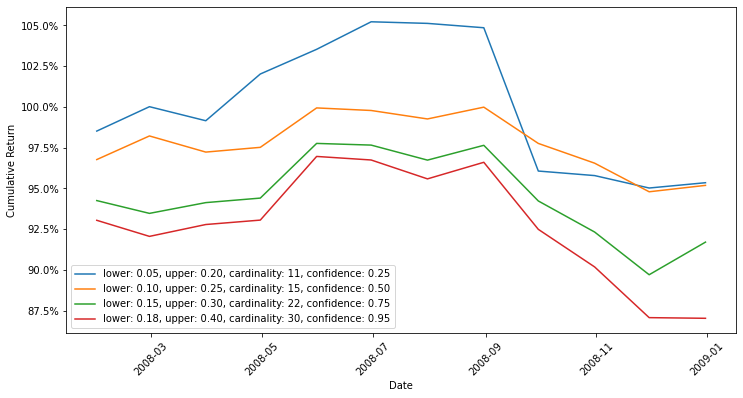

In [107]:
legend_list=["lower: 0.05, upper: 0.20, cardinality: 11, confidence: 0.25","lower: 0.10, upper: 0.25, cardinality: 15, confidence: 0.50","lower: 0.15, upper: 0.30, cardinality: 22, confidence: 0.75","lower: 0.18, upper: 0.40, cardinality: 30, confidence: 0.95"]
plot_comparison(portfolio_set_bear[0:4],legend_list)

In [115]:
# New Bull Tuning.. Use CVaR
import time 
upper_limit= 0.25
lower_limit= 0.05
stock_limit= 15
conf_level=0.5
constr_list = ['asset_limit_cardinality']

low_risk_profiles = 0.05
med_risk_profiles = 0.1
high_risk_profiles = 0.15

start_date = '2015-12-01'
end_date = '2020-12-01'

back_test = Backtest(start_date, end_date)
CVAR_port_factors= Portfolio(data)
CVAR_port_copula=Portfolio(data)

scen_factor_start= time.time()
CVAR_sharpe_factors = back_test.run(data, CVAR_port_factors, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="CVAR",scen_type=0)
scen_factor_end= time.time()

scen_copula_start=time.time()
CVAR_sharpe_copula = back_test.run(data, CVAR_port_copula, low_risk_profiles, factor_model,conf_level,constr_list, u_lim=upper_limit, l_lim=lower_limit,
                               stock_lim=stock_limit, risk_type="CVAR",scen_type=1)
scen_copula_end=time.time()

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.009036900705896377
robustness cost: 0.022259823901071858
risk value: [0.0030057]
holding cost: 0.0
trans cost: 0.0027770768048245207
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal R

Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.004326458111087096
robustness cost: 0.015771426256517417
risk value: [0.00970739]
holding cost: 0.0
trans cost: 0.00455503185456968
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.004418163901114717
robustness cost: 0.018016318319264788
risk value: [0.01113921]
holding cost: 0.0
trans cost: 0.002029994550793425
Unsolvable, Reducing Return Target
Temporary Goal Return is:

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Goal returns: -0.008
port return raw: 0.022066807664352463
robustness cost: 0.02579473865603327
risk value: [0.0003003]
holding cost: 0.0
trans cost: 0.004272069008319193
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Goal returns: -0.002
port return raw: 0.0224962164832823
robustness cost: 0.023486217978759275
risk value: [0.04204784]
holding cost: 0.0
trans cost: 

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.007991683932385297
robustness cost: 0.02097516349749507
risk value: [-0.00097261]
holding cost: 0.0
trans cost: 0.003016520434890223
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.005751863145573438
robustness cost: 0.019081972884249898
risk value: [0.00214251]
holding cost: 0.0
trans cost: 0.002669890261323544
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004


Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.006063569633197001
robustness cost: 0.019522778688379063
risk value: [0.01459301]
holding cost: 0.0
trans cost: 0.001
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.0047574412503600064
robustness cost: 0.015041584252054825
risk value: [0.01082234]
holding cost: 0.0
trans cost: 0.002
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.00

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Goal returns: -0.008
port return raw: 0.02651184947556532
robustness cost: 0.029223244962079616
risk value: [0.00033593]
holding cost: 0.0
trans cost: 0.005288604513485703
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Uns

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.00570525267001888
robustness cost: 0.01750007970399256
risk value: [0.01342555]
holding cost: 0.0
trans cost: 0.004
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Re

Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.006818007439311356
robustness cost: 0.016773477496958122
risk value: [0.00731866]
holding cost: 0.0
trans cost: 0.001
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.003259299026918683
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.0026074392215349462
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.002085951377227957
Unsolvable, Reducing Return Target
Temporary Goal Return is: 0.001668761101782366
Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port retur

Unsolvable, Reducing Return Target
Temporary Goal Return is: -0.001
Temporary Goal Return is: -0.002
Temporary Goal Return is: -0.004
Temporary Goal Return is: -0.008
Temporary Goal Return is: -0.016
Goal returns: -0.016
port return raw: 0.005708415977581791
robustness cost: 0.02068556720405626
risk value: [0.01535433]
holding cost: 0.0
trans cost: 0.001


In [116]:
scen_factor_end-scen_factor_start

2750.4637928009033

In [117]:
scen_copula_end-scen_copula_start

607.4210755825043

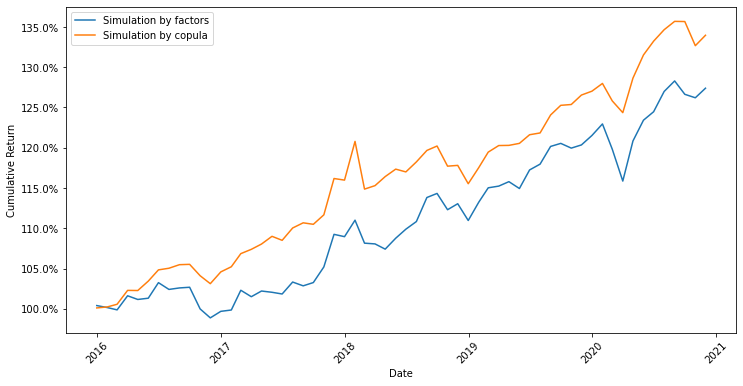

In [119]:
plot_comparison([CVAR_port_factors, CVAR_port_copula], ["Simulation by factors", "Simulation by copula"])

In [120]:
time_factor_sim=scen_factor_end-scen_factor_start
time_copula_sim=scen_copula_end-scen_copula_start

In [ ]:
print("Factor simulation")